In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib
import matplotlib.pyplot as plt
import gymnasium as gym
import gym_anytrading
import math
from collections import namedtuple, deque
import random

# Define the transition tuple
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory:
    def __init__(self, capacity=1000000):
        self.memory = deque([], maxlen=capacity)
        
    def push(self, *args):
        self.memory.append(Transition(*args))
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [2]:
class DQN(nn.Module):
    
    def __init__(self, input_dim, n_actions):
        super(DQN, self).__init__()
        self.policy_net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256,128),
            nn.ReLU(),
            nn.Linear(128, n_actions),
        )
        
    def forward(self, state):
        return self.policy_net(state)



In [3]:
class DQNAgent:
    def __init__(self, input_dim, n_actions, eps=0.9, lr=0.0005):
        self.memory = ReplayMemory()
        self.input_dim = input_dim
        self.n_actions = n_actions
        self.lr = lr
        self.eps = eps
        self.policy_net = DQN(self.input_dim, self.n_actions)
        self.target_net = DQN(self.input_dim, self.n_actions)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.lr)

    def select_action(self, state, eps_decay=0.995, eps_end=0.01, eps_start=0.9):
        global steps_done
        sample = random.random()
        eps_threshold = eps_end + (eps_start - eps_end) * math.exp(-1 * steps_done / eps_decay)
        steps_done += 1
        if sample > self.eps:
            self.eps *= eps_decay 
            with torch.no_grad():
                return self.policy_net(state).max(1)[1].view(1, 1)
        else:
            return torch.tensor([[random.randrange(self.n_actions)]], dtype=torch.long)

    def optimize(self, batch_size=128, gamma=0.99):
        if len(self.memory) < batch_size:
            return
        transitions = self.memory.sample(batch_size)
        batch = Transition(*zip(*transitions))
        
        non_terminal_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), dtype=torch.bool)
        non_terminal_next_states = torch.cat([s for s in batch.next_state if s is not None])
        
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        
        state_action_values = self.policy_net(state_batch).gather(1, action_batch)
        next_state_values = torch.zeros(batch_size)
        next_state_values[non_terminal_mask] = self.target_net(non_terminal_next_states).max(1)[0].detach()
        expected_state_action_values = (next_state_values * gamma) + reward_batch
        
        loss = nn.functional.mse_loss(state_action_values, expected_state_action_values.unsqueeze(1))
        

        
        # Zero out gradients
        for param in self.policy_net.parameters():
            if param.grad is not None:
                param.grad.data.zero_()
                
        loss.backward()
        
        torch.nn.utils.clip_grad_value_(agent.policy_net.parameters(), clip_value=1.0)
        # Manual update using gradients
        for param in self.policy_net.parameters():
            param.data -= self.lr * param.grad.data
        

In [4]:
def train(env, agent, episode, T, gamma=0.99):
    state, _ = env.reset()
    
    episode_reward = 0
    for t in range(T):
        state = state.flatten()
        state_tensor = torch.tensor([state], dtype=torch.float32)
        action = agent.select_action(state_tensor)
        next_state, reward, terminated, truncated, info = env.step(action.item())
        done = terminated or truncated
        episode_reward += reward
        if done:
            next_state = None
        else:
            next_state = next_state.flatten()
        agent.memory.push(state_tensor, action, torch.tensor([next_state], dtype=torch.float32) if next_state is not None else None, torch.tensor([reward], dtype=torch.float32))
        state = next_state
        agent.optimize()
        if episode % 5 == 0:
            agent.target_net.load_state_dict(agent.policy_net.state_dict())
        if done:
            break
    return episode_reward, info



In [5]:
env = gym.make('forex-v0', frame_bound=(10, 500), window_size=10)
input_dim = env.observation_space.shape[1] * env.observation_space.shape[0]
n_actions = env.action_space.n
T = env.frame_bound[1] - env.frame_bound[0]
agent = DQNAgent(input_dim, n_actions)
steps_done = 0
num_episodes = 300
for episode in range(num_episodes):
    reward, info = train(env, agent, episode, T)
    print(f"Episode: {episode+1}, Reward: {reward}")
    print("info: ", info)
    print()

/Users/ryankan/anaconda3/lib/python3.11/site-packages/gymnasium/core.py:297: UserWarning: WARN: env.frame_bound to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.frame_bound` for environment variables or `env.get_attr('frame_bound')` that will search the reminding wrappers.
  logger.warn(
/var/folders/jv/c7kjn4v159b6c6q5vxtjnp_w0000gn/T/ipykernel_54491/3286400277.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)
  state_tensor = torch.tensor([state], dtype=torch.float32)


Episode: 1, Reward: -21.693706512451172
info:  {'total_reward': -21.693706512451172, 'total_profit': 0.9619747573966421, 'position': <Positions.Long: 1>}

Episode: 2, Reward: -515.1975154876709
info:  {'total_reward': -515.1975154876709, 'total_profit': 0.9536687844309145, 'position': <Positions.Short: 0>}

Episode: 3, Reward: -170.80307006835938
info:  {'total_reward': -170.80307006835938, 'total_profit': 0.981101668136292, 'position': <Positions.Short: 0>}

Episode: 4, Reward: 0
info:  {'total_reward': 0.0, 'total_profit': 0.9831577054220703, 'position': <Positions.Short: 0>}

Episode: 5, Reward: 0
info:  {'total_reward': 0.0, 'total_profit': 0.9831577054220703, 'position': <Positions.Short: 0>}

Episode: 6, Reward: 0
info:  {'total_reward': 0.0, 'total_profit': 0.9831577054220703, 'position': <Positions.Short: 0>}

Episode: 7, Reward: 0
info:  {'total_reward': 0.0, 'total_profit': 0.9831577054220703, 'position': <Positions.Short: 0>}

Episode: 8, Reward: 0
info:  {'total_reward': 0.

KeyboardInterrupt: 

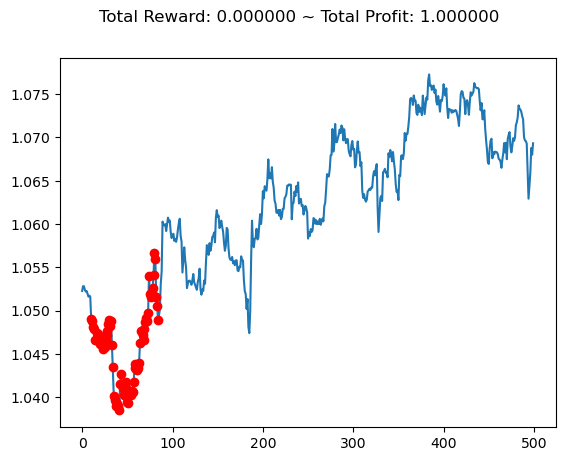

In [6]:
plt.cla()
env.unwrapped.render_all()
plt.show()
